# Import Libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import nltk
import string
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# Acquire Data

In [ ]:
import pickle
import pandas as pd
from google.colab import drive
# Connect to google drive
drive.mount('/content/gdrive')

# Load data and set labels
#data = pickle.load(open('gdrive/My Drive/Dissertation/formspring_data.pkl', 'rb'))
df = pd.read_csv('gdrive/My Drive/Dissertation/enriched_processed_form+tweet.csv', index_col=0)

Mounted at /content/gdrive


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,39079.0,122.354948,76.555517,7.0,64.0,107.0,144.0,910.0
No_of_Words,39079.0,26.075718,16.100767,3.0,14.0,23.0,33.0,99.0
No_of_sentence,39079.0,2.058190,1.268395,1.0,1.0,2.0,3.0,30.0
label,39079.0,0.500345,0.500006,0.0,0.0,1.0,1.0,1.0
sent_length,39079.0,20.579237,13.958837,1.0,10.0,17.0,26.0,93.0


In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,39079.0,122.354948,76.555517,7.0,64.0,107.0,144.0,910.0
No_of_Words,39079.0,26.075718,16.100767,3.0,14.0,23.0,33.0,99.0
No_of_sentence,39079.0,2.058190,1.268395,1.0,1.0,2.0,3.0,30.0
label,39079.0,0.500345,0.500006,0.0,0.0,1.0,1.0,1.0
sent_length,39079.0,20.579237,13.958837,1.0,10.0,17.0,26.0,93.0


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import defaultdict
from plotly import tools
from plotly.offline import iplot

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Encode data

In [ ]:
from sklearn import model_selection, metrics, svm
from sklearn.svm import SVC

###TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfIdf_Vectorization(corpus):
  vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2), max_df = 0.8, sublinear_tf=True, use_idf=True)
  tdidf_tensor = vectorizer.fit_transform(corpus)
  return tdidf_tensor

In [ ]:
corpus = df['X'].values.astype('U')
tfidf_tensor= tfIdf_Vectorization(corpus)
print('shape',tfidf_tensor.shape)

shape (39079, 27016)


In [ ]:
tfidf_tensor

<39079x27016 sparse matrix of type '<class 'numpy.float64'>'
	with 1061312 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.preprocessing import MinMaxScaler # Importing to do standardisation
from sklearn.model_selection import train_test_split #Importing to split our data for training
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score,confusion_matrix, classification_report,mean_squared_error
from collections import Counter 
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
X = tfidf_tensor
y = df.label.values

# Split data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, train_size=0.90, stratify=y, random_state=40)

In [ ]:
#svm_tf_idf = SVC()
svm_tf_idf = svm.SVC(C=5, kernel='rbf', degree=3, gamma=0.5)
svm_tf_idf.fit(X_train_tfidf, y_train)

SVC(C=5, gamma=0.5)

In [ ]:
%time
svm_pred = svm_tf_idf.predict(X_test_tfidf)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


In [ ]:
#Defining function to update classification reports in pandas dataframes
def get_classification_report(y_test, y_pred):
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report
    return df_classification_report

Evaluation Metrics for SVM model:


,precision,recall,f1-score,support
0,0.837394,0.862263,0.849647,1953.000000
1,0.858197,0.832737,0.845275,1955.000000
accuracy,0.847492,0.847492,0.847492,0.847492
macro avg,0.847796,0.847500,0.847461,3908.000000
weighted avg,0.847801,0.847492,0.847460,3908.000000


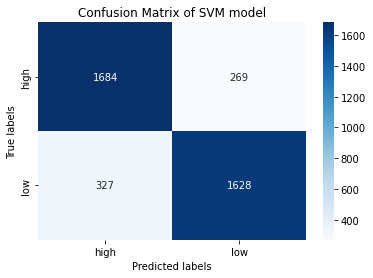

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#Defining variables for confusion matrices:
rf_conf = confusion_matrix(y_test,svm_pred)

#Plotting Confusion Matrix
ax= plt.subplot()
sns.heatmap(rf_conf, annot=True, fmt='g', ax=ax,cmap='Blues');  #annot=True to annotate cells, fmt='g' to disable scientific notation
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of SVM model')
ax.xaxis.set_ticklabels(['high', 'low','medium'])
ax.yaxis.set_ticklabels(['high', 'low', 'medium']);

#Calling get_classification_report function to print the evaluation metrics:
rf_report = get_classification_report(y_test,svm_pred) 
print("================================")
print("Evaluation Metrics for SVM model:")
print("================================")
rf_report

In [ ]:
#Evaluating the model before GridSearchCV:
scores = cross_val_score(svm_tf_idf, X_train_tfidf, y_train, cv=5)

print("Accuracy of SVM model:",round(scores.mean()*100,2),"%")

Accuracy of SVM model: 84.4 %


##Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=50)
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=50)

In [ ]:
%time
rf_pred = rf.predict(X_test_tfidf)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


Evaluation Metrics for RFC model


,precision,recall,f1-score,support
0,0.801373,0.896569,0.846303,1953.000000
1,0.882763,0.778005,0.827080,1955.000000
accuracy,0.837257,0.837257,0.837257,0.837257
macro avg,0.842068,0.837287,0.836691,3908.000000
weighted avg,0.842089,0.837257,0.836686,3908.000000


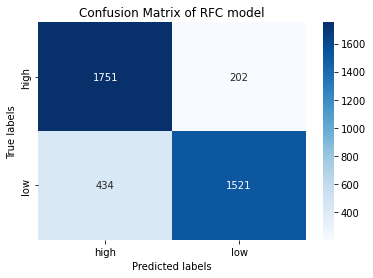

In [ ]:
rf_conf = confusion_matrix(y_test,rf_pred)

#Plotting Confusion Matrix
ax= plt.subplot()
sns.heatmap(rf_conf, annot=True, fmt='g', ax=ax,cmap='Blues');  #annot=True to annotate cells, fmt='g' to disable scientific notation
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of RFC model')
ax.xaxis.set_ticklabels(['high', 'low','medium'])
ax.yaxis.set_ticklabels(['high', 'low', 'medium']);

#Calling get_classification_report function to print the evaluation metrics:
rf_report = get_classification_report(y_test,rf_pred) 
print("================================")
print("Evaluation Metrics for RFC model")
print("================================")
rf_report

In [ ]:
#Evaluating the model before GridSearchCV:
scores = cross_val_score(rf, X_train_tfidf, y_train, cv=5)

print("Accuracy of RF model: ",round(scores.mean()*100,2),"%")

Accuracy of RF model:  84.16 %
